# MLB Power Rankings and Casino Odds
> Part 3 - adding power rankings and odds into the MLB prediction model

- toc: false
- badges: true
- comments: true
- categories: [baseball, webscraping, Elo, Trueskill, Glick]
- image: images/chart-preview.png

Last time, we created a model that performs pretty well just based on the statistics that we downloaded from [baseball-reference.com](http://baseball-reference.com). In this post, we'll extend that model by adding power rankings and casino odds to the model.
> Important: You can run this notebook from Colab or Binder using the buttons above, but you'll also need the files we created in Part 2.

## Power Rankings
The 538 Blog has famously modified the [Elo system](https://en.wikipedia.org/wiki/Elo_rating_system) from chess to make [their baseball rankings](https://projects.fivethirtyeight.com/2020-mlb-predictions/). The Elo system tries to determine the relative skill level of a player based on the skill levels of the other players encountered. If you beat a person with a high skill level, your skill level is going to improve more than if you win against a player of the same or lower skill level than you. And if your skill level is higher than your opponent's then you will probably win the match.

If 538 thinks Elo is foundational, then we should definitely put it in our model. The trouble is that not everyone agrees on how to implement it. In fact there are a whole family of different power ranking systems out there. In this project we're going to add four: 2 varieties of Elo ([slow and fast changing](https://en.wikipedia.org/wiki/Elo_rating_system#Most_accurate_K-factor)), [Glicko](https://en.wikipedia.org/wiki/Glicko_rating_system), and [Trueskill](https://en.wikipedia.org/wiki/TrueSkill). Luckily people have created libraries to help us get the code right.
>Important: If you are running this notebook online, you may need to install the additional libraries. [Here's how to do it on Colab](https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb).

Let's get to it. We'll start by importing our dataframe from Part 2.

In [1]:
import pickle
df = pickle.load(open("dataframe.pkl","rb"))

### Elo Rankings
For Elo rankings, we're going to use the [elote library](https://github.com/helton-tech/elote), primarily because it's named after the Mexican habit of eating corn on the cob with mayonnaise (yuck!). Install it like this:
```
pip install elote
```

In [2]:
from elote import EloCompetitor
ratings = {}
for x in df.home_team_abbr.unique():
    ratings[x]=EloCompetitor()
for x in df.away_team_abbr.unique():
    ratings[x]=EloCompetitor()

home_team_elo = []
away_team_elo = []
elo_exp = []

df = df.sort_values(by='date').reset_index(drop=True)
for i, r in df.iterrows():
    # get pre-game ratings
    elo_exp.append(ratings[r.home_team_abbr].expected_score(ratings[r.away_team_abbr]))
    home_team_elo.append(ratings[r.home_team_abbr].rating)
    away_team_elo.append(ratings[r.away_team_abbr].rating)
    # update ratings
    if r.home_team_win:
        ratings[r.home_team_abbr].beat(ratings[r.away_team_abbr])
    else:
        ratings[r.away_team_abbr].beat(ratings[r.home_team_abbr])

df['elo_exp'] = elo_exp
df['home_team_elo'] = home_team_elo
df['away_team_elo'] = away_team_elo


Now we'll do the slow changing version, where we decrease the k-factor.

In [3]:
ratings = {}
for x in df.home_team_abbr.unique():
    ratings[x]=EloCompetitor()
    ratings[x]._k_score=16
for x in df.away_team_abbr.unique():
    ratings[x]=EloCompetitor()
    ratings[x]._k_score=16

home_team_elo = []
away_team_elo = []
elo_exp = []

df = df.sort_values(by='date').reset_index(drop=True)
for i, r in df.iterrows():
    # get pregame ratings
    elo_exp.append(ratings[r.home_team_abbr].expected_score(ratings[r.away_team_abbr]))
    home_team_elo.append(ratings[r.home_team_abbr].rating)
    away_team_elo.append(ratings[r.away_team_abbr].rating)
    # update ratings
    if r.home_team_win:
        ratings[r.home_team_abbr].beat(ratings[r.away_team_abbr])
    else:
        ratings[r.away_team_abbr].beat(ratings[r.home_team_abbr])

df['elo_slow_exp'] = elo_exp
df['home_team_elo_slow'] = home_team_elo
df['away_team_elo_slow'] = away_team_elo


### Glicko Ratings
Glicko can be calculated using the same library.

In [4]:
from elote import GlickoCompetitor
ratings = {}
for x in df.home_team_abbr.unique():
    ratings[x]=GlickoCompetitor()
for x in df.away_team_abbr.unique():
    ratings[x]=GlickoCompetitor()

home_team_glick = []
away_team_glick = []
glick_exp = []

df = df.sort_values(by='date').reset_index(drop=True)
for i, r in df.iterrows():
    # get pregame ratings
    glick_exp.append(ratings[r.home_team_abbr].expected_score(ratings[r.away_team_abbr]))
    home_team_glick.append(ratings[r.home_team_abbr].rating)
    away_team_glick.append(ratings[r.away_team_abbr].rating)
    # update ratings
    if r.home_team_win:
        ratings[r.home_team_abbr].beat(ratings[r.away_team_abbr])
    else:
        ratings[r.away_team_abbr].beat(ratings[r.home_team_abbr])

df['glick_exp'] = glick_exp
df['home_team_glick'] = home_team_glick
df['away_team_glick'] = away_team_glick

### Trueskill Ratings
Trueskill was invented for Microsoft video games on the XBox. It's something you need to license if you are going to use it for commercial purposes. Trueskill ratings are a little bit more complex, because we have the opportunity to include the starting pitcher skill as well. Install the [python package](https://trueskill.org/) like this:
```
pip install trueskill
```

In [5]:
from trueskill import Rating, quality, rate
ratings = {}
for x in df.home_team_abbr.unique():
    ratings[x]=Rating(25)
for x in df.away_team_abbr.unique():
    ratings[x]=Rating(25)
for x in df.home_pitcher.unique():
    ratings[x]=Rating(25)
for x in df.away_pitcher.unique():
    ratings[x]=Rating(25)

ts_quality = []
pitcher_ts_diff = []
team_ts_diff = []
home_pitcher_ts = []
away_pitcher_ts = []
home_team_ts = []
away_team_ts = []
df = df.sort_values(by='date').copy()
for i, r in df.iterrows():
    # get pre-match trueskill ratings from dict
    match = [(ratings[r.home_team_abbr], ratings[r.home_pitcher]),
            (ratings[r.away_team_abbr], ratings[r.away_pitcher])]
    ts_quality.append(quality(match))
    pitcher_ts_diff.append(ratings[r.home_pitcher].mu-ratings[r.away_pitcher].mu)
    team_ts_diff.append(ratings[r.home_team_abbr].mu-ratings[r.away_team_abbr].mu)
    home_pitcher_ts.append(ratings[r.home_pitcher].mu)
    away_pitcher_ts.append(ratings[r.away_pitcher].mu)
    home_team_ts.append(ratings[r.home_team_abbr].mu)
    away_team_ts.append(ratings[r.away_team_abbr].mu)

    if r.date < df.date.max():
        # update ratings dictionary with post-match ratings
        if r.home_team_win==1:
            match = [(ratings[r.home_team_abbr], ratings[r.home_pitcher]),
                     (ratings[r.away_team_abbr], ratings[r.away_pitcher])]
            [(ratings[r.home_team_abbr], ratings[r.home_pitcher]),
            (ratings[r.away_team_abbr], ratings[r.away_pitcher])] = rate(match)
        else:
            match = [(ratings[r.away_team_abbr], ratings[r.away_pitcher]),
                     (ratings[r.home_team_abbr], ratings[r.home_pitcher])]
            [(ratings[r.away_team_abbr], ratings[r.away_pitcher]),
            (ratings[r.home_team_abbr], ratings[r.home_pitcher])] = rate(match)

df['ts_game_quality'] = ts_quality
df['pitcher_ts_diff'] = pitcher_ts_diff
df['team_ts_diff'] = team_ts_diff
df['home_pitcher_ts'] = home_pitcher_ts
df['away_pitcher_ts'] = away_pitcher_ts
df['home_team_ts'] = home_team_ts
df['away_team_ts'] = away_team_ts

That's all we need for power rankings. Let's move on.
## Casino Odds
Having the casino odds in our model is really going to improve its predictions, but getting them in there is kind of a pain in the ass. The problem is that we need to match the games from two different systems (baseball-reference.com and covers.com). These systems don't use the same team abbreviations and don't even agree on what time the games started. So there's a bit of code to compensate.

But it starts the same as in Part 1 of this blog series - we need to find out which days to download odds data for. We'll use our dataframe to get this list.

In [56]:
import pandas as pd
dates = pd.to_datetime(df['date'], unit='s')
game_days = dates.dt.strftime('%Y-%m-%d').unique()
print("Days of odds data needed:", len(game_days))


Days of odds data needed: 882


The below code is largely the same from Part 1, except we are also grabbing team abbreviations from the data

In [23]:
import requests
from bs4 import BeautifulSoup as bs
import datetime as dt

game_data = []
for d in game_days:
    # get the web page with game data on it
    url = f'https://www.covers.com/Sports/MLB/Matchups?selectedDate={d}'
    resp = requests.get(url)

    # parse the games
    scraped_games = bs(resp.text).findAll('div',{'class':'cmg_matchup_game_box'})
    for g in scraped_games:
        game = {}
        game['home_moneyline'] = g['data-game-odd']
        game['date'] = g['data-game-date']
        game['away_team_abbr'] = g['data-away-team-shortname-search']
        game['home_team_abbr'] = g['data-home-team-shortname-search']
        try:
            game['home_score'] =g.find('div',{'class':'cmg_matchup_list_score_home'}).text.strip()
            game['away_score'] =g.find('div',{'class':'cmg_matchup_list_score_away'}).text.strip()
        except:
            game['home_score'] =''
            game['away_score'] =''

        game_data.append(game)
        if len(game_data) % 1000==0:
            #show progress
            print(dt.datetime.now(), d, len(game_data))
print("Done! Games downloaded:", len(game_data))

2020-09-22 11:05:50.761606 2016-06-15 1000
2020-09-22 11:06:49.874100 2016-08-31 2000
2020-09-22 11:08:01.555549 2017-05-10 3000
2020-09-22 11:08:59.782088 2017-07-24 4000
2020-09-22 11:10:12.009463 2018-03-29 5000
2020-09-22 11:11:15.911291 2018-06-10 6000
2020-09-22 11:12:19.081595 2018-08-26 7000
2020-09-22 11:13:33.951630 2019-05-01 8000
2020-09-22 11:14:32.515388 2019-07-17 9000
2020-09-22 11:15:31.501830 2019-09-29 10000
Done! Games downloaded: 10914


So slow. Let's save this so we don't have to go through that again.

In [24]:
import pickle
pickle.dump(game_data, open('covers_data_2.pkl','wb'))

We'll do some prepping and cleaning of the data.

In [6]:
import pickle
game_data = pickle.load(open('covers_data_2.pkl','rb'))

In [9]:
import numpy as np
import pandas as pd
odds = pd.DataFrame(game_data)
odds['home_moneyline'].replace('', np.nan, inplace=True)
odds.dropna(subset=['home_moneyline'], inplace=True)
odds.home_moneyline = pd.to_numeric(odds.home_moneyline)
odds.date = pd.to_datetime(odds.date).dt.date

Now we convert the team names to be the same as baseball-reference.com



In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

odds.home_team_abbr[odds.home_team_abbr=='SF']='SFG'
odds.home_team_abbr[odds.home_team_abbr=='TB']='TBR'
odds.home_team_abbr[odds.home_team_abbr=='WAS']='WSN'
odds.home_team_abbr[odds.home_team_abbr=='KC']='KCR'
odds.home_team_abbr[odds.home_team_abbr=='SD']='SDP'

odds.away_team_abbr[odds.away_team_abbr=='SF']='SFG'
odds.away_team_abbr[odds.away_team_abbr=='TB']='TBR'
odds.away_team_abbr[odds.away_team_abbr=='WAS']='WSN'
odds.away_team_abbr[odds.away_team_abbr=='KC']='KCR'
odds.away_team_abbr[odds.away_team_abbr=='SD']='SDP'

Finally, convert the moneyline odds to probabilities


In [11]:
odds['odds_proba']=np.nan
odds['odds_proba'][odds.home_moneyline<0] = -odds.home_moneyline/(-odds.home_moneyline + 100)
odds['odds_proba'][odds.home_moneyline>0] = (100/(odds.home_moneyline + 100))


Because the game times aren't exact, we'll use [pandas merge_asof](https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html) to find the closest match. The syntax is that you the fields in "by" parameter need to be exact, and it will find the closest by the "on" parameter. I think this feature is awesome, and another reason I love pandas.


In [12]:
print('dataframe shape before merge:', df.shape)
# get dates into the same format
odds['date'] = (pd.to_datetime(pd.to_datetime(odds['date'])) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# do the merge
df = pd.merge_asof(left=df.sort_values(by='date'),
                   right=odds[['home_team_abbr','date', 'away_team_abbr','odds_proba']].sort_values(by='date'),
                   by=['home_team_abbr','away_team_abbr'],
                   on='date')
df = df.sort_values(by='date').copy().reset_index(drop=True)
print('dataframe shape after merge:', df.shape)

dataframe shape before merge: (10492, 1016)
dataframe shape after merge: (10492, 1017)


Things look good now. Let's save this dataframe before we move on

In [13]:
import pickle
pickle.dump(df, open('dataframe_part3.pkl','wb'))

## Run The Model
This is almost the exact code we ran in part 2

In [15]:
import pickle
df = pickle.load(open('dataframe_part3.pkl','rb'))


In [16]:
import xgboost as xgb

# target encoding
encode_me = [x for x in df.keys() if 'object' in str(df[x].dtype)]
for x in encode_me:
    df[x] = df.groupby(x)['home_team_win'].apply(lambda x:x.rolling(180).mean()).shift(1)

# create test, train splits
df = df.sort_values(by='date').copy().reset_index(drop=True)
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

X_train = X[:-1000]
y_train = y[:-1000]
X_valid = X[-1000:-500]
y_valid = y[-1000:-500]
X_test = X[-500:]
y_test = y[-500:]


Run the model

In [17]:
params = {'learning_rate': 0.075,'max_depth': 4}
gbm = xgb.XGBClassifier(**params)
model = gbm.fit(X_train, y_train,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                eval_metric='logloss',
                early_stopping_rounds=10)
xgb_test_preds = model.predict(X_test)
xgb_test_proba = model.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.68855	validation_1-logloss:0.68919
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68441	validation_1-logloss:0.68602
[2]	validation_0-logloss:0.68068	validation_1-logloss:0.68400
[3]	validation_0-logloss:0.67736	validation_1-logloss:0.68144
[4]	validation_0-logloss:0.67433	validation_1-logloss:0.68012
[5]	validation_0-logloss:0.67159	validation_1-logloss:0.67901
[6]	validation_0-logloss:0.66903	validation_1-logloss:0.67868
[7]	validation_0-logloss:0.66654	validation_1-logloss:0.67790
[8]	validation_0-logloss:0.66440	validation_1-logloss:0.67730
[9]	validation_0-logloss:0.66216	validation_1-logloss:0.67634
[10]	validation_0-logloss:0.65985	validation_1-logloss:0.67627
[11]	validation_0-logloss:0.65795	validation_1-logloss:0.67603
[12]	validation_0-logloss:0.65602	validation_1-logloss:0.67588
[13]	validation_0-logloss:

And our results...

Casino		Accuracy:0.6006	 Brier Loss: 0.2358
XGBoost		Accuracy:0.6120	 Brier Loss: 0.2384


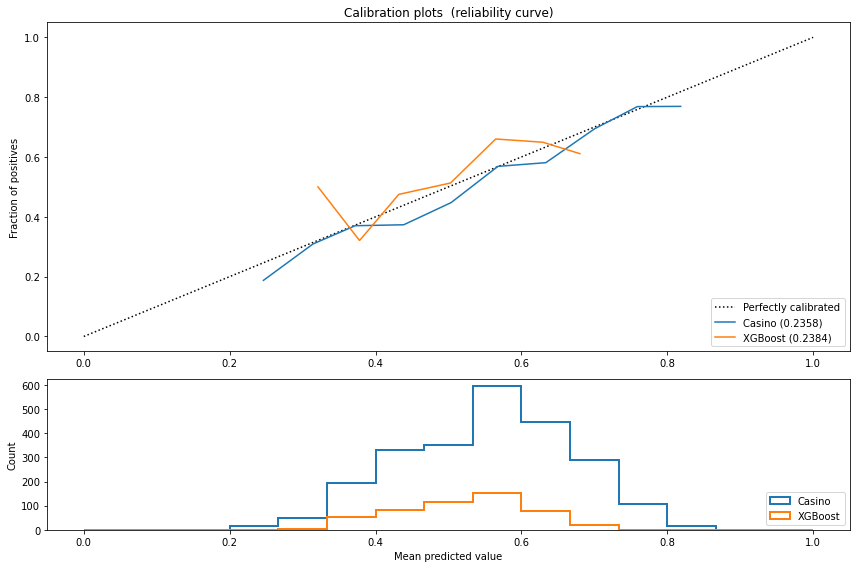

In [18]:
#collapse-hide
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt
import pickle

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\t\tAccuracy:{:.4f}\t Brier Loss: {:.4f}".format(
            name, accuracy_score(y_test, y_pred), brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

outcomes,predictions,probabilities = pickle.load(open('baseline.pkl','rb'))
data = [
    (outcomes, predictions, probabilities, 'Casino'),
    (y_test,xgb_test_preds, xgb_test_proba, 'XGBoost')
]
cal_curve(data, 15)

Now we're talking. Our accuracy in our test data is 1.1% better than the oddsmakers and our calibration is virtually the same. Looking at our feature importances below, we can see that the odds dominate the importances, but our power rankings also are among the top features. Interestingly, almost none of the features that were important in the Part 2 blog post are still important. XGBoost is fickle.

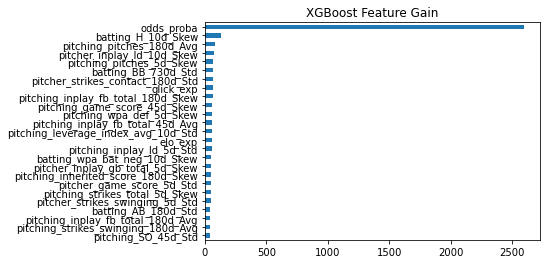

In [19]:
#collapse-hide
import pandas as pd
x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
_ = x[-25:].plot(kind='barh',title="XGBoost Feature Gain")

## Next up
In Part 4, we're going to train this thing for real, and try to squeak out a few more % through downloading more data and hyperparameter optimization. You may want to run the next notebook overnight...

